In [ ]:
!pip install pydot

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from keras.models import Sequential
from keras.layers import Dense
#necessita do pydot pip install pydot
from keras.utils.vis_utils import plot_model
import pydot

A primeira coisa que vamos fazer é ler o conjunto de dados usando a função read_csv() dos Pandas. 
Colocaremos esses dados em um DataFrame do Pandas, chamado "titanic", e nomearemos cada uma das colunas.

In [ ]:
url = 'https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv'
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head(10)

VARIABLE DESCRIPTIONS:
<ol>
<li>Survived - Survival (0 = No; 1 = Yes);</li>
<li>Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd);</li>
<li>Name - Name;</li>
<li>Sex - Sex;</li>
<li>Age - Age;</li>
<li>SibSp - Number of Siblings/Spouses Aboard;</li>
<li>Parch - Number of Parents/Children Aboard;</li>
<li>Ticket - Ticket Number;</li>
<li>Fare - Passenger Fare (British pound);</li>
<li>Cabin - Cabin;</li>
<li>Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton);</li>
</ol>

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
Para ter certeza de que é uma variável binária, vamos usar a função countplot() do Seaborn.

Como estamos construindo um modelo para prever a sobrevivência de passageiros do Titanic, nosso alvo será a variável "Survived" do dataframe titanic.
Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn.

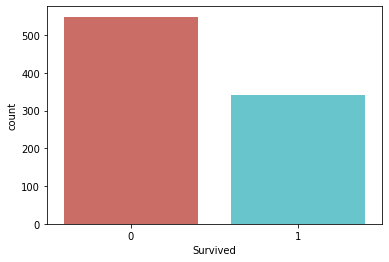

In [ ]:
sb.countplot(x='Survived',data=titanic, palette='hls')

### Checking for missing values
É fácil checar missing values usando método isnull() com o método sum(), o número retornado condiz com a quantidade True para o teste, ou seja, quantidade de valores nulos nas variaveis

In [ ]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Ok, então existem 891 linhas no dataframe. Cabin é quase todo composto por missing values, então podemos eliminar essa característica! Mas e quanto à idade? A age parece um preditor relevante para a sobrevivência, certo? Nós queremos manter as variáveis, mas tem 177 missing values. Precisamos encontrar uma maneira de nos aproximarmos desses valores em falta!

E quanto ao nome de uma pessoa, número do bilhete e número de identificação do passageiro? Eles são irrelavantes para prever a capacidade de sobrevivência. E, como você se lembra, a variável cabine é quase todoa com missing values!!

In [ ]:
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], axis = 1)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
titanic_data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Agora, o dataframe foi reduzido para apenas variáveis relevantes, mas agora precisamos lidar com os valores ausentes na variável age.

### Imputing missing values
Vejamos como a idade do passageiro está relacionada à sua classe como passageiro no barco.

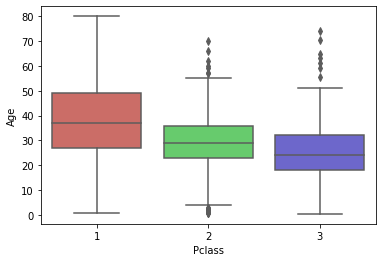

In [ ]:
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

Falando mais ou menos, poderíamos dizer que quanto mais jovem é um passageiro, mais provável é que ele esteja na 3ª classe. Quanto mais velho for um passageiro, maior a probabilidade de estarem na 1ª classe. Portanto, há um relacionamento frouxo entre essas variáveis. Então, vamos escrever uma função que se aproxime da idade dos passageiros, com base em sua classe. Na caixa, parece que a idade média dos passageiros de 1ª classe é de cerca de 37 anos, os passageiros de 2ª classe são 29 e os passageiros de 3ª classe são 24.

Então, vamos escrever uma função que encontre cada valor nulo na variável Age e, para cada nulo, verifique o valor da Pclass e atribua um valor de idade de acordo com a idade média dos passageiros nessa classe.

In [ ]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

Após definir a função, vamos executar apenas para os valores nulos de Age

In [ ]:
titanic_data[['Age', 'Pclass']]

In [ ]:
titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)

In [ ]:
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

Existem ainda 2 valores nulos na variável Embarked. Podemos eliminar esses dois registros sem perder muitas informações importantes do nosso conjunto de dados, então faremos isso.

In [ ]:
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [ ]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Convertendo variaveis categóricas com one-hot-enconding (via pandas usa-se a função get_dummies)
![Exemplo de One Hoting Encoding](https://telescopeinstorage.blob.core.windows.net/datasets/onehotencoding.jpg)

In [ ]:
aux = pd.get_dummies(titanic_data['Sex'],drop_first=False)
aux.head()

In [ ]:
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [ ]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head(10)

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
5,1,0
6,0,1
7,0,1
8,0,1
9,0,0


In [ ]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [ ]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


Agora temos um conjunto de dados com todas as variáveis no formato correto!
### Validando independencia entre as variáveis

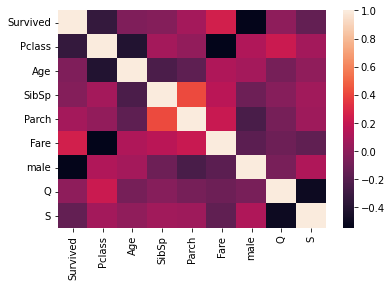

In [ ]:
sb.heatmap(titanic_dmy.corr())  

Fare e Pclass não sao independentes uma com a outra, entao vamos excluí-las.

In [ ]:
titanic_dmy.drop(['Pclass'],axis=1,inplace=True)
titanic_dmy.head()

O mesmo processo vale para as características C e Q

In [ ]:
titanic_dmy.drop(['Q'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,Fare,male,S
0,0,22.0,1,0,7.2500,1,1
1,1,38.0,1,0,71.2833,0,0
2,1,26.0,0,0,7.9250,0,1
3,1,35.0,1,0,53.1000,0,1
4,0,35.0,0,0,8.0500,1,1


### Agora Vamos Classificar!

1º: Separar o conjunto em variavel resposta e características de treinamento

In [ ]:
X = titanic_dmy.iloc[:,[1,2,3,4,5,6]].values
y = titanic_dmy.iloc[:,0].values

In [ ]:
X.shape

(889, 6)

In [ ]:
X

array([[22.    ,  1.    ,  0.    ,  7.25  ,  1.    ,  1.    ],
       [38.    ,  1.    ,  0.    , 71.2833,  0.    ,  0.    ],
       [26.    ,  0.    ,  0.    ,  7.925 ,  0.    ,  1.    ],
       ...,
       [24.    ,  1.    ,  2.    , 23.45  ,  0.    ,  1.    ],
       [26.    ,  0.    ,  0.    , 30.    ,  1.    ,  0.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ,  1.    ,  0.    ]])

In [ ]:
len(y)

889

Normalização do Conjunto

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
X

Agora dividir em treino e teste (teste com 30%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [ ]:
X_train.shape

(622, 6)

#### Cria o Modelo de Rede Neural

![Modelo de RNA](https://telescopeinstorage.blob.core.windows.net/datasets/RNA_6_16_1.png)

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=6, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Compila do modelo para certificar que está correto utilizando a função de perda binary_crossentropy, gradiente adam e monitorará a acurácia ao longo do processo de treinamento:

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Apresenta a configuração da rede:

In [ ]:
print(model.summary())

plot_model(model, to_file='mlp-seq.png', show_shapes=True, show_layer_names=True)

Realiza o treinamento com 100 épocas e o tamanho do batch igual a 10, lembrando que a cada batch o processo de calibragem dos neurônios é realizado novamente (backpropagation). Uma época termina quando todas as amostras de treinamento passam pela rede.

In [ ]:
history  = model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
63/63 [==============================] - 1s 1ms/step - loss: 0.6566 - accuracy: 0.6543
Epoch 2/100
63/63 [==============================] - 0s 1ms/step - loss: 0.6017 - accuracy: 0.7347
Epoch 3/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5607 - accuracy: 0.7492
Epoch 4/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5286 - accuracy: 0.7508
Epoch 5/100
63/63 [==============================] - 0s 1ms/step - loss: 0.5067 - accuracy: 0.7653
Epoch 6/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4891 - accuracy: 0.7749
Epoch 7/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4774 - accuracy: 0.7814
Epoch 8/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4693 - accuracy: 0.7846
Epoch 9/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4634 - accuracy: 0.7797
Epoch 10/100
63/63 [==============================] - 0s 1ms/step - loss: 0.4590 - accuracy: 0.7830
Epoch 11/

Faz a plotagem a acurácia de treinamento ao longo das épocas

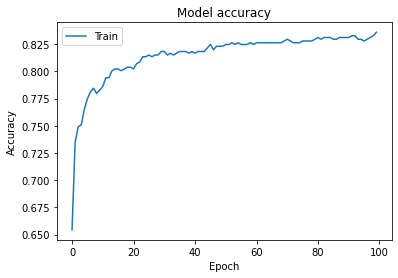

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


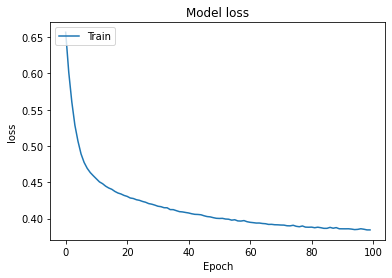

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Realiza as predições do conjunto de teste obtendo a saída real (numérica) do Neurônio

In [ ]:
y_pred_out  = model.predict(X_test)
print(y_pred_out)

Realiza as predições do conjunto de teste obtendo a classe do problema:

In [ ]:
y_test

In [ ]:
import numpy as np

In [ ]:
y_pred_classes = (y_pred_out > 0.5).astype(int) 
y_pred_classes


In [ ]:
y_test

Avalia o modelo sob o ponto de vista da acurácia no conjunto de teste:

In [ ]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

9/9 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.7940

accuracy: 79.40%


In [ ]:
scores

[0.4777766466140747, 0.7940074801445007]

In [ ]:
model.metrics_names

['loss', 'accuracy']